In [399]:
import numpy as np 
import pandas as pd
import copy
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler as under_sam

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

# Main implementation

In [400]:
# loading the train set
df_train = pd.read_csv('EvalResources/KDDTrain+.txt', sep=",", header=None, skipinitialspace = True)
df_train = df_train[df_train.columns[:-1]]  # tags column
titles = pd.read_csv('EvalResources/Field Names.csv', header=None, skipinitialspace = True)
label = pd.Series(['label'], index=[41])
titles = pd.concat([titles[0], label])
df_train.columns = titles.to_list()
df_train = df_train.drop(['num_outbound_cmds'],axis=1)
df_train_original = df_train

# df_train_original.to_csv('KB Process/NSL-KDD Original Datasets/KDDTrain+_with_labels.txt', index=False)

#df_train_original

In [401]:
# load test set
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace = True)
df_test_ = df_test.sort_index(axis=1)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
df_test = df_test.drop(['num_outbound_cmds'],axis=1)
df_test_original = df_test

# df_test_original.to_csv('KB Process/NSL-KDD Original Datasets/KDDTest+.txt', index=False)

#df_test_original

### Execution Parameters

In [402]:
EXPORT_MODELS = 0
EXPORT_DATASETS = 0
EXPORT_PCA = 0
EXPORT_ENCODERS = 0

pd.options.display.max_columns = None

In [403]:
# list of single attacks 
dos_attacks = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'worm', 'apache2', 'mailbomb', 'processtable', 'udpstorm']
probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
r2l_attacks = ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
                'snmpguess', 'spy', 'warezclient', 'httptunnel', 'named', 'sendmail', 'snmpgetattack', 'xlock', 'xsnoop']
u2r_attacks = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'] 

# list of attack classes split according to detection layer
dos_probe_list = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'ipsweep', 'nmap', 'portsweep', 'satan']
dos_probe_test = ['apache2', 'mailbomb', 'processtable', 'udpstorm', 'mscan', 'saint']
u2r_r2l_list = ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
                'snmpguess', 'spy', 'warezclient', 'buffer_overflow', 'loadmodule', 'rootkit', 'perl']
u2r_r2l_test = ['httptunnel', 'named', 'sendmail', 'snmpgetattack', 'xlock', 'xsnoop', 'ps', 'xterm', 'sqlattack']
normal_list = ['normal']
categorical_features = ['protocol_type', 'service', 'flag']

In [404]:
# load the features obtained with ICFS for both layer 1 and layer 2
with open('KBProcess/AWS Downloads/MinimalFeatures/NSL_features_l1.txt', 'r') as f:
    common_features_l1 = f.read().split(',')

with open('KBProcess/AWS Downloads/MinimalFeatures/NSL_features_l2.txt', 'r') as f:
    common_features_l2 = f.read().split(',')

In [405]:
df_train_and_validate = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

In [406]:
# Save all the targets for the dataset

y_test_l1 = [1 if x in (dos_attacks+probe_attacks) else 0 for x in df_test['label']]
y_test_l2 = [1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_test['label']]

if EXPORT_DATASETS:
    np.save("EvalResources/AdditionalSets/l1_full_test_targets.npy", y_test_l1)
    np.save("EvalResources/AdditionalSets/l2_full_test_targets.npy", y_test_l2)

In [407]:
# add an additional column to th dataframe to perform splitting

attacks = ['dos' if x in dos_attacks else
           'probe' if x in probe_attacks else
           'u2r' if x in u2r_attacks else
           'r2l' if x in r2l_attacks else
           'normal' for x in df_train_and_validate['label']]

# add the column to the dataframe
df_train_and_validate['attacks'] = attacks

# DOS PROBE CLASSIFIER

In [408]:
# split in test and validation set for BOTH layers
df_train_original, df_val_original = train_test_split(df_train_and_validate, test_size=0.3, stratify=df_train_and_validate['attacks'])

import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'column_name' is the specific column you want to plot
plt.hist(df_val_original['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
plt.show()

import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'column_name' is the specific column you want to plot
plt.hist(df_train_original['attacks'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Histogram of Column')  # Set title
plt.show()

In [409]:
# dataframes specifically for layer 1
df_train = copy.deepcopy(df_train_original)
df_val = copy.deepcopy(df_val_original)
df_test = copy.deepcopy(df_test_original)

# target variables for all layers
y_train_full = np.array([1 if x not in normal_list else 0 for x in df_train['label']])
y_test_full = np.array([1 if x not in normal_list else 0 for x in df_test['label']])

# set the target variables accordingly
y_train_l1 = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_train['label']])
y_validate_l1 = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_val['label']])
y_test = np.array([1 if x in (dos_attacks+probe_attacks) else 0 for x in df_test ['label']])

In [410]:
# this dataframe contains the whole train set 
df_train = df_train.drop(['label'],axis=1)
df_train = df_train.reset_index().drop(['index'], axis=1)
#df_train

In [411]:
# this dataframe contains the whole validation set
df_val = df_val.drop(['label'],axis=1)
df_val = df_val.reset_index().drop(['index'], axis=1)
#df_val

In [412]:
# this dataframe contains the whole test set
df_test = df_test.drop(['label'],axis=1)
df_test = df_test.reset_index().drop(['index'], axis=1)
#df_test

## Using features obtained with a random forest on numerical features only

# List of feature names
feature_names_l1 = ['src_bytes', 'logged_in', 'count', 'srv_count', 'srv_serror_rate',
       'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']

# Selecting features using loc
X_train = df_train.loc[:, feature_names_l1]
X_validate = df_val.loc[:, feature_names_l1]
X_test = df_test.loc[:, feature_names_l1]

In [413]:
# Using the features extracted by using the ICFS algorithm
X_train = df_train[common_features_l1]
X_validate = df_val[common_features_l1]
X_test = df_test[common_features_l1]

In [414]:
# 2 one-hot encoders, one for the features of layer1 and one for the features of layer2
ohe = OneHotEncoder(handle_unknown='ignore')
ohe2 = OneHotEncoder(handle_unknown='ignore')

In [415]:
scaler1 = MinMaxScaler()

In [416]:
scaler2 = MinMaxScaler()

In [417]:
# scaling the train set for layer1
df_minmax = scaler1.fit_transform(X_train)
X_train = pd.DataFrame(df_minmax, columns=X_train.columns)

#X_train

In [418]:
# scaling the validation set for layer1
df_minmax_val = scaler1.transform(X_validate)
X_validate = pd.DataFrame(df_minmax_val, columns=X_validate.columns)

#X_validate

In [419]:
# scaling the test set for layer1
df_minmax_test = scaler1.transform(X_test)
X_test = pd.DataFrame(df_minmax_test, columns=X_test.columns)

#X_vtest

In [420]:
# perform One-hot encoding for the train set
label_enc = ohe.fit_transform(df_train[categorical_features])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_train = pd.concat([X_train, df_enc], axis=1)

In [421]:
# perform One-hot encoding for the validation set
label_enc = ohe.transform(df_val[categorical_features])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_validate = pd.concat([X_validate, df_enc], axis=1)

#X_validate

In [422]:
# perform One-hot encoding for the test set
label_enc = ohe.transform(df_test[categorical_features])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test = pd.concat([X_test, df_enc], axis=1)

#X_test

In [423]:
print('Shape of the whole train set: ', X_train.shape)
print('Shape of its targets: ', y_train_l1.shape)
print('Shape of the whole train set: ', X_validate.shape)
print('Shape of its targets: ', y_validate_l1.shape)
print('Shape of the whole test set: ', X_test.shape)
print('Shape of its targets: ', y_test.shape)

Shape of the whole train set:  (88181, 100)
Shape of its targets:  (88181,)
Shape of the whole train set:  (37792, 100)
Shape of its targets:  (37792,)
Shape of the whole test set:  (22544, 100)
Shape of its targets:  (22544,)


# Export the dataset for training layer 1
if EXPORT_DATASETS:
    X_train.to_csv('EvalResources/ProcessedDatasets/x_train_l1.txt', index=False)
    X_validate.to_csv('EvalResources/ProcessedDatasets/x_val_l1.txt', index=False)
    np.save('EvalResources/ProcessedWithPCA/y_train_l1', y_train_l1)
    np.save('EvalResources/ProcessedWithPCA/y_val_l1', y_validate_l1)
    np.save('EvalResources/ProcessedWithPCA/y_test_l1', y_test)

### Principal Component Analysis

In [424]:
pca_dos_probe = PCA(n_components=0.95)
X_train_dos_probe = pca_dos_probe.fit_transform(X_train)
X_test_dos_probe = pca_dos_probe.transform(X_test)
X_validate_dos_probe = pca_dos_probe.transform(X_validate)

# X_train = X_train.sort_index(axis=1)
X_train_dos_probe.shape

(88181, 28)

if EXPORT_PCA:
    # save the pca transformed datasets for layer1
    column_names = [f'PC{i}' for i in range(1, X_test_dos_probe.shape[1] + 1)]
    x = pd.DataFrame(data=X_test_dos_probe, columns=column_names)
    x.to_csv('EvalResources/ProcessedDatasets/KDDTest+_l1_pca.txt', index=False)
    
    column_names = [f'PC{i}' for i in range(1, X_train_dos_probe.shape[1] + 1)]
    x = pd.DataFrame(data=X_train_dos_probe, columns=column_names)
    x.to_csv('EvalResources/ProcessedDatasets/KDDTrain+_l1_pca.txt', index=False)
    
    column_names = [f'PC{i}' for i in range(1, X_validate_dos_probe.shape[1] + 1)]
    x = pd.DataFrame(data=X_validate_dos_probe, columns=column_names)
    x.to_csv('EvalResources/ProcessedDatasets/KDDValidate+_l1_pca.txt', index=False)
    
    # save the correspondant target values
    np.save("EvalResources/ProcessedDatasets//KDDTrain+_l1_targets", y_train_l1)
    np.save("EvalResources/ProcessedDatasets/KDDValidate+_l1_targets", y_validate_l1)
    np.save("EvalResources/ProcessedDatasets//KDDTest+_l1_targets", y_test)

### Building the classifier for the layer1

In [425]:
from datetime import datetime

In [426]:
# Voting classifiers

voting_classifiers = []

from sklearn.ensemble import HistGradientBoostingClassifier

# Using HistGradientBoosting classifier
dos_probe_classifier = HistGradientBoostingClassifier()

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train_l1)
ttime = datetime.now() - start


voting_classifiers.append(("hgbc", dos_probe_classifier))

In [427]:
# Using Random Forest Classifier
dos_probe_classifier = RandomForestClassifier()

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train_l1)
ttime = datetime.now() - start

voting_classifiers.append(("rf", dos_probe_classifier))

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Metrics for layer 1:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)

# test the other classifiers obtained in the evaluation phase
dos_probe_classifier = joblib.load("TunerProcess/TunedModels/l1_classifier.pkl")
#classifier2 = joblib.load("TunerProcess/TunedModels/l1_classifier.pkl")

# Using the Naive Bayes Classifier
dos_probe_classifier = GaussianNB()

voting_classifiers.append(("nbc", dos_probe_classifier))

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train_l1)
ttime = datetime.now() - start

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Metrics for layer 1:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the train set for l1: ', X_train_dos_probe.shape)

# Voting classifier

from sklearn.ensemble import VotingClassifier

dos_probe_classifier = VotingClassifier(estimators=voting_classifiers, voting='soft')

start = datetime.now()
dos_probe_classifier.fit(X_train_dos_probe, y_train_l1)
ttime = datetime.now() - start

predicted = dos_probe_classifier.predict(X_test_dos_probe)

print('Using a voting classifier:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the train set for l1: ', X_train_dos_probe.shape)

# R2L+U2R classifier

In [428]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)
df_val = copy.deepcopy(df_val_original)

# load targeted attacks (Normal + r2l + u2r)
df_train = df_train[df_train['label'].isin(normal_list+u2r_attacks+r2l_attacks)]
df_val = df_val[df_val['label'].isin(normal_list+u2r_attacks+r2l_attacks)]
df_test = df_test[df_test['label'].isin(normal_list+u2r_attacks+r2l_attacks)]

# set the target variables accordingly
y_train_l2 = np.array([1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_train['label']])
y_validate_l2 = np.array([1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_val['label']])
y_test = np.array([1 if x in (u2r_attacks+r2l_attacks) else 0 for x in df_test['label']])

df_train = df_train.drop(['label'],axis=1)
df_train = df_train.reset_index().drop(['index'], axis=1)
#df_train

In [429]:
df_val = df_val.drop(['label'],axis=1)
df_val = df_val.reset_index().drop(['index'], axis=1)
#df_val

In [430]:
df_test = df_test.drop(['label'],axis=1)
df_test = df_test.reset_index().drop(['index'], axis=1)
#df_test

In [431]:
X_train = df_train
X_validate = df_val
X_test = df_test

## Using features obtained with a random forest on numerical features only

# List of feature names
feature_names_l2 = ['count', 'is_guest_login', 'srv_count', 'hot', 'dst_host_serror_rate',
       'dst_host_srv_count', 'dst_host_count', 'dst_host_same_srv_rate',
       'dst_host_same_src_port_rate', 'num_file_creations', 'diff_srv_rate']

# Selecting features using loc
X_train = df_train.loc[:, feature_names_l2]
X_validate = df_val.loc[:, feature_names_l2]
X_test = df_test.loc[:, feature_names_l2]

In [432]:
X_train = df_train[common_features_l2]
X_validate = df_val[common_features_l2]
X_test = df_test[common_features_l2]

In [433]:
df_minmax = scaler2.fit_transform(X_train)
X_train = pd.DataFrame(df_minmax, columns=X_train.columns)
#X_train

In [434]:
df_minmax = scaler2.transform(X_validate)
X_validate = pd.DataFrame(df_minmax, columns=X_validate.columns)
#X_validate

In [435]:
df_minmax = scaler2.transform(X_test)
X_test = pd.DataFrame(df_minmax, columns=X_test.columns)
#X_test

In [436]:
# perform One-hot encoding for the train set
label_enc = ohe2.fit_transform(df_train[categorical_features])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_train = pd.concat([X_train, df_enc], axis=1)
#X_train

In [437]:
# perform One-hot encoding for the validation set
label_enc = ohe2.transform(df_val[categorical_features])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_validate = pd.concat([X_validate, df_enc], axis=1)
#X_validate

In [438]:
# perform One-hot encoding for the test set
label_enc = ohe2.transform(df_test[categorical_features])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test = pd.concat([X_test, df_enc], axis=1)
#X_test

In [439]:
print('Shape of the train set: ', X_train.shape)
print('Shape of its target: ', y_train_l2.shape)
print('Shape of the test set: ', X_test.shape)
print('Shape of its target: ', y_test.shape)

Shape of the train set:  (47873, 51)
Shape of its target:  (47873,)
Shape of the test set:  (12663, 51)
Shape of its target:  (12663,)


In [440]:
# Under sampling the train set for l2
sm = under_sam(sampling_strategy=1)
X_train, y_train_l2 = sm.fit_resample(X_train,y_train_l2)

## Export the datasets
Train set has been scaled, one hot encoded, undersampled
Test set has been scaled and one hot encoded

# Export the dataset for training layer 2
if EXPORT_DATASETS:
    # X_train.to_csv('EvalResources/ProcessedDatasets/x_train_l2.txt', index=False)
    np.save('EvalResources/ProcessedWithPCA/y_train_l2', y_train_l2)
    # X_validate.to_csv('EvalResources/ProcessedDatasets/x_val_l2.txt', index=False)
    np.save('EvalResources/ProcessedWithPCA/y_val_l2', y_val)
    np.save('EvalResources/ProcessedWithPCA/y_test_l2', y_test)

In [441]:
# Principal Component Analysis
pca_r2l_u2r = PCA(n_components=0.95)
X_train_r2l_u2r = pca_r2l_u2r.fit_transform(X_train)
X_test_r2l_u2r = pca_r2l_u2r.transform(X_test)
X_validate_r2l_u2r = pca_r2l_u2r.transform(X_validate)

In [442]:
# Support Vector Machine for layer l2
r2l_u2r_classifier = SVC(probability=True)

#r2l_u2r_classifier = SVC()

start = datetime.now()
r2l_u2r_classifier.fit(X_train_r2l_u2r, y_train_l2)
ttime = datetime.now() - start

predicted = r2l_u2r_classifier.predict(X_test_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_test,predicted))
print('Accuracy = ', accuracy_score(y_test,predicted))
print('F1 Score = ', f1_score(y_test,predicted))
print('Precision = ', precision_score(y_test,predicted))
print('Recall = ', recall_score(y_test,predicted))
print('Matthew corr = ', matthews_corrcoef(y_test,predicted))
print('Train time = ', ttime)
print('Shape of the training set: ', X_train_r2l_u2r.shape)

predicted = r2l_u2r_classifier.predict(X_train_r2l_u2r)

print('Metrics for layer 2:')
print('Confusion matrix: [TP FN / FP TN]\n', confusion_matrix(y_train_l2,predicted))
print('Accuracy = ', accuracy_score(y_train_l2,predicted))
print('F1 Score = ', f1_score(y_train_l2,predicted))
print('Precision = ', precision_score(y_train_l2,predicted))
print('Recall = ', recall_score(y_train_l2,predicted))
print('Matthew corr = ', matthews_corrcoef(y_train_l2,predicted))

if EXPORT_PCA:
    # save the pca transformed as well as the transformer
    column_names = [f'PC{i}' for i in range(1, X_test_r2l_u2r.shape[1] + 1)]
    x = pd.DataFrame(data=X_test_r2l_u2r, columns=column_names)
    x.to_csv('EvalResources/ProcessedDatasets/KDDTest+_l2_pca.txt', index=False)
    
    column_names = [f'PC{i}' for i in range(1, X_train_r2l_u2r.shape[1] + 1)]
    x = pd.DataFrame(data=X_train_r2l_u2r, columns=column_names)
    x.to_csv('EvalResources/ProcessedDatasets/KDDTrain+_l2_pca.txt', index=False)
    
    column_names = [f'PC{i}' for i in range(1, X_validate_r2l_u2r.shape[1] + 1)]
    x = pd.DataFrame(data=X_validate_r2l_u2r, columns=column_names)
    x.to_csv('EvalResources/ProcessedDatasets/KDDValidate+_l2_pca.txt', index=False)

    # export the correspondant targets values
    np.save("EvalResources/ProcessedDatasets//KDDTrain+_l2_targets", y_train_l2)
    np.save("EvalResources/ProcessedDatasets/KDDValidate+_l2_targets", y_validate_l2)
    np.save("EvalResources/ProcessedDatasets//KDDTest+_l2_targets", y_test)

### Export the classifiers

if EXPORT_MODELS:
    with open('EvalResources/Models/HGBC/l1_classifier.pkl', "wb") as f:
        pickle.dump(dos_probe_classifier, f)
    with open('EvalResources/Models/HGBC/l2_classifier.pkl', "wb") as f:
        pickle.dump(r2l_u2r_classifier, f)

# Export one hot encoders
if EXPORT_ENCODERS:
    joblib.dump(ohe, 'EvalResources/Encoders/ohe_l1.pkl')
    joblib.dump(ohe2, 'EvalResources/Encoders/ohe_l2.pkl')
    joblib.dump(scaler1, 'EvalResources/Encoders/Scaler_l1.pkl')
    joblib.dump(scaler2, 'EvalResources/Encoders/Scaler_l2.pkl')
    joblib.dump(pca_dos_probe, 'EvalResources/Encoders/pca_transformer_l1.pkl')
    joblib.dump(pca_r2l_u2r, 'EvalResources/Encoders/pca_transformer_l2.pkl')

# Testing

In [443]:
df_test1 = copy.deepcopy(df_test_original)
df_test2 = copy.deepcopy(df_test_original)

y_test_real = np.array([0 if x=='normal' else 1 for x in df_test1['label']])

np.save("EvalResources/Test/KDDTest+_targets", y_test_real)

In [444]:
y_test_real.shape

(22544,)

X_test1 = df_test1.loc[:, feature_names_l1]

In [445]:
X_test1 = df_test1[common_features_l1]

In [446]:
df_minmax = scaler1.transform(X_test1)
X_test1 = pd.DataFrame(df_minmax, columns=X_test1.columns)
label_enc = ohe.transform(df_test1.iloc[:,1:4])
label_enc.toarray()
new_labels = ohe.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test1 = pd.concat([X_test1, df_enc], axis=1)

X_test_layer1 = pca_dos_probe.transform(X_test1)
print('Test set shape for layer 1: ', X_test_layer1.shape)

Test set shape for layer 1:  (22544, 28)


In [447]:
#X_test1

In [448]:
X_test2 = df_test2

X_test2 = df_test2.loc[:, feature_names_l2]

In [449]:
X_test2 = df_test2[common_features_l2] 

In [450]:
df_minmax = scaler2.transform(X_test2)
X_test2 = pd.DataFrame(df_minmax, columns=X_test2.columns)
label_enc = ohe2.transform(df_test2.iloc[:,1:4])
label_enc.toarray()
new_labels = ohe2.get_feature_names_out(categorical_features)
df_enc = pd.DataFrame(data=label_enc.toarray(), columns=new_labels)
X_test2 = pd.concat([X_test2, df_enc], axis=1)

X_test_layer2 = pca_r2l_u2r.transform(X_test2)
print('Test set shape for layer 1: ', X_test_layer1.shape)
print('Test set shape for layer 2: ', X_test_layer2.shape)

Test set shape for layer 1:  (22544, 28)
Test set shape for layer 2:  (22544, 13)


In [451]:
#X_test_layer1

In [452]:
#X_test_layer2

In [453]:
# same classifiers obtained above
classifier1 = dos_probe_classifier
classifier2 = r2l_u2r_classifier

In [454]:
import warnings

# Suppressing the warning
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

import numpy as np
from datetime import datetime

def test_metrics():
    result_ = []
    tn, fp, fn, tp = 0, 0, 0, 0
    
    start_ = datetime.now()
    
    for i in range(X_test_layer2.shape[0]):
        layer1_ = classifier1.predict(X_test_layer1[i].reshape(1, -1))[0]
        if layer1_ == 1:
            result_.append(layer1_)
        else:
            layer2_ = classifier2.predict(X_test_layer2[i].reshape(1, -1))[0]
            if layer2_ == 1:
                result_.append(layer2_)
            else:
                result_.append(0)
        # Evaluate confusion matrix
        if y_test_real[i] == 1:
            if result_[-1] == 1:
                tp += 1
            else:
                fn += 1
        else:
            if result_[-1] == 1:
                fp += 1
            else:
                tn += 1
    
    clf_time_ = datetime.now() - start_
    
    # Calculate rates
    tnr_ = tn / (tn + fp)
    fpr_= fp / (fp + tn)
    fnr_ = fn / (fn + tp)
    
    return (accuracy_score(y_test_real,np.array(result_)), 
            f1_score(y_test_real, np.array(result_)),
            precision_score(y_test_real, np.array(result_)),
            recall_score(y_test_real, np.array(result_)),
            clf_time_, tnr_, fpr_, fnr_, np.array(result_))

In [455]:
# the results may vary
accuracy, f_score, precision, recall, clf_time, tnr, fpr, fnr, result = test_metrics()

print('Accuracy = ', accuracy)
print('F1 Score = ', f_score)
print('Precision = ', precision)
print('Recall = ', recall)
print('Classification time = ', clf_time)
print('False Positive Rate (FPR) =', fpr)
print('True Negative Rate (TNR) =', tnr)
print('False Negative Rate (FNR) =', fnr)

Accuracy =  0.7982611781405252
F1 Score =  0.7939097335508429
Precision =  0.9485652409312398
Recall =  0.6826151328605938
Classification time =  0:01:45.432754
False Positive Rate (FPR) = 0.0489136031304706
True Negative Rate (TNR) = 0.9510863968695294
False Negative Rate (FNR) = 0.3173848671394062


# Run the function multiple times and accumulate results
num_iterations = 5
total_accuracy = 0
total_f1_score = 0
total_precision = 0
total_recall = 0
total_clf_time = 0
total_tnr = 0
total_fpr = 0
total_fnr = 0

for _ in range(num_iterations):
    acc, f1, prec, rec, clf_time, tnr, fpr, fnr, _ = test_metrics()
    total_accuracy += acc
    total_f1_score += f1
    total_precision += prec
    total_recall += rec
    total_tnr += tnr
    total_fpr += fpr
    total_fnr += fnr

# Calculate averages
avg_accuracy = total_accuracy / num_iterations
avg_f1_score = total_f1_score / num_iterations
avg_precision = total_precision / num_iterations
avg_recall = total_recall / num_iterations
avg_tnr = total_tnr / num_iterations
avg_fpr = total_fpr / num_iterations
avg_fnr = total_fnr / num_iterations

print('Average Accuracy:', avg_accuracy)
print('Average F1 Score:', avg_f1_score)
print('Average Precision:', avg_precision)
print('Average Recall:', avg_recall)
print('Average TNR:', avg_tnr)
print('Average FPR:', avg_fpr)
print('Average FNR:', avg_fnr)

In [456]:
# load testset
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace=True)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'], axis=1)

df_test_original = df_test
if EXPORT_DATASETS:
    df_test_original.to_csv('EvalResources/ProcessedDatasets/x_test_full.txt', index=False)
    np.save('EvalResources/ProcessedDatasets/y_test_full', y_test)

#df_test_original
new_attack = []
for i in df_test_original['label'].value_counts().index.tolist()[1:]:
    if i not in df_train_original['label'].value_counts().index.tolist()[1:]:
        new_attack.append(i)

new_attack.sort()
#new_attack
index_of_new_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] in new_attack:
        index_of_new_attacks.append(df_test_original.index[i])

new_attack.append('normal')

index_of_old_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] not in new_attack:
        index_of_old_attacks.append(df_test_original.index[i])
print('Number of new attacks in the test set: ', result[index_of_new_attacks].shape[0])
print('Number of new attacks detected by the classifiers: ', result[index_of_new_attacks].sum())
print('Proportion of new attacks detected: ',
      result[index_of_new_attacks].sum() / result[index_of_new_attacks].shape[0])
print('Number of old attacks in the test set: ', result[index_of_old_attacks].shape[0])
print('Number of old attacks detected by the classifiers: ', result[index_of_old_attacks].sum())
print('Proportion of old attacks detected: ',
      result[index_of_old_attacks].sum() / result[index_of_old_attacks].shape[0])

Number of new attacks in the test set:  3750
Number of new attacks detected by the classifiers:  1358
Proportion of new attacks detected:  0.3621333333333333
Number of old attacks in the test set:  9083
Number of old attacks detected by the classifiers:  7402
Proportion of old attacks detected:  0.8149289882197512


In [457]:
### Evaluate single attack types
# load test set
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace=True)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'], axis=1)
df_test_original = df_test
df = df_test_original

dos_index = df.index[(df['label'].isin(dos_attacks))].tolist()
probe_index = df.index[(df['label'].isin(probe_attacks))].tolist()
r2l_index = df.index[(df['label'].isin(r2l_attacks))].tolist()
u2r_index = df.index[(df['label'].isin(u2r_attacks))].tolist()

print("Ratio of DOS detection: ", result[dos_index].sum() / result[dos_index].shape[0])

print("Ratio of PROBE detection: ", result[probe_index].sum() / result[probe_index].shape[0])

print("Ratio of U2R detection: ", result[r2l_index].sum() / result[r2l_index].shape[0])

print("Ratio of R2L detection: ", result[u2r_index].sum() / result[u2r_index].shape[0])

print('New attacks detected: ',
      result[index_of_new_attacks].sum() / result[index_of_new_attacks].shape[0])

print('Old attacks detected: ',
      result[index_of_old_attacks].sum() / result[index_of_old_attacks].shape[0])

Ratio of DOS detection:  0.7777479892761394
Ratio of PROBE detection:  0.8194960760016522
Ratio of U2R detection:  0.32062391681109187
Ratio of R2L detection:  0.7313432835820896
New attacks detected:  0.3621333333333333
Old attacks detected:  0.8149289882197512


# Now start the adaptation process

In [294]:
from sklearn.metrics import precision_score
import optuna

# S1 RF + SVM

In [ ]:
## Define the space of hyperparameters for Random Forest
rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

## Define the space of hyperparameters for SVM
svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    # Initialize and train Random Forest classifier
    rf_classifier = RandomForestClassifier(**rf_hyperparams)
    rf_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    rf_predicted = rf_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    rf_precision = precision_score(y_validate_l1, rf_predicted)
    svm_precision = precision_score(y_validate_l2, svm_predicted)
    
    rf_recall = recall_score(y_validate_l1, rf_predicted)
    svm_recall = recall_score(y_validate_l2, svm_predicted)
    
    # Calculate weighted average of TPR and Precision (you can adjust weights based on preference)
    weighted_score = (0.5 * (rf_recall + svm_recall)) + (0.5 * (rf_precision + svm_precision))
    
    return weighted_score


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S1 (RF+NBC) + SVM

rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    
    """
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    # Initialize the rf
    rf_classifier = RandomForestClassifier(**rf_hyperparams)
    
    # Initialize the nbc
    nbc_classifier = GaussianNB(**gnb_hyperparams)
    
    # Initialize and train voting classifier
    voting_classifier = VotingClassifier(
        estimators=[("rf", rf_classifier), ("nbc", nbc_classifier)] ,
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    voting_precision = precision_score(y_validate_l1, voting_predicted)
    svm_precision = precision_score(y_validate_l2, svm_predicted)
    
    voting_recall = recall_score(y_validate_l1, voting_predicted)
    svm_recall = recall_score(y_validate_l2, svm_predicted)
    
    # Calculate weighted average of TPR and Precision (you can adjust weights based on preference)
    weighted_score = (0.5 * (voting_recall + svm_recall)) + (0.5 * (voting_precision + svm_precision))
    
    return weighted_score


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S1 (HGBC+NBC) + SVM

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for HistGradientBoostingClassifier
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    # Initialize the hgbc
    hgbc_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    
    # Initialize the nbc
    nbc_classifier = GaussianNB(**gnb_hyperparams)
    
    # Initialize and train voting classifier
    voting_classifier = VotingClassifier(
        estimators=[("hgbc", hgbc_classifier), ("nbc", nbc_classifier)] ,
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    voting_precision = precision_score(y_validate_l1, voting_predicted)
    svm_precision = precision_score(y_validate_l2, svm_predicted)
    
    voting_recall = recall_score(y_validate_l1, voting_predicted)
    svm_recall = recall_score(y_validate_l2, svm_predicted)
    
    # Calculate weighted average of TPR and Precision (you can adjust weights based on preference)
    weighted_score = (0.5 * (voting_recall + svm_recall)) + (0.5 * (voting_precision + svm_precision))
    
    return weighted_score


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S1 HGBC + SVM

from sklearn.ensemble import HistGradientBoostingClassifier

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for HistGradientBoostingClassifier
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }

    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    
    """
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    # Initialize and train HistGradientBoostingClassifier
    hgb_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    hgb_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    hgb_predicted = hgb_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    hgb_precision = precision_score(y_validate_l1, hgb_predicted)
    svm_precision = precision_score(y_validate_l2, svm_predicted)
    
    hgb_recall = recall_score(y_validate_l1, hgb_predicted)
    svm_recall = recall_score(y_validate_l2, svm_predicted)
    
    # Calculate weighted average of TPR and Precision (you can adjust weights based on preference)
    weighted_score = (0.5 * (hgb_recall + svm_recall)) + (0.5 * (hgb_precision + svm_precision))
    
    return weighted_score


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S2 (RF+NBC) + SVM

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    # Initialize the rf
    rf_classifier = RandomForestClassifier(**rf_hyperparams)
    
    # Initialize the nbc
    nbc_classifier = GaussianNB(**gnb_hyperparams)
    
    # Initialize and train voting classifier
    voting_classifier = VotingClassifier(
        estimators=[("rf", rf_classifier), ("nbc", nbc_classifier)] ,
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    voting_cm = confusion_matrix(y_validate_l1, voting_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Positive Rates for both classifiers
    voting_fpr = voting_cm[0, 1] / np.sum(voting_cm[0, :])
    svm_fpr = svm_cm[0, 1] / np.sum(svm_cm[0, :])
    
    # Calculate the average FPR
    avg_fpr = (voting_fpr + svm_fpr) / 2
    
    return avg_fpr


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S2 (HGBC+NBC) + SVM

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for HistGradientBoostingClassifier
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    # Initialize the rf
    hgb_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    
    # Initialize the nbc
    nbc_classifier = GaussianNB(**gnb_hyperparams)
    
    # Initialize and train voting classifier
    voting_classifier = VotingClassifier(
        estimators=[("hgbc", hgb_classifier), ("nbc", nbc_classifier)] ,
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    voting_cm = confusion_matrix(y_validate_l1, voting_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Positive Rates for both classifiers
    voting_fpr = voting_cm[0, 1] / np.sum(voting_cm[0, :])
    svm_fpr = svm_cm[0, 1] / np.sum(svm_cm[0, :])
    
    # Calculate the average FPR
    avg_fpr = (voting_fpr + svm_fpr) / 2
    
    return avg_fpr


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S2 HGBC + SVM

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for HistGradientBoostingClassifier
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    # Initialize the rf
    hgb_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    hgb_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    hgb_predicted = hgb_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    hgb_cm = confusion_matrix(y_validate_l1, hgb_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Positive Rates for both classifiers
    voting_fpr = hgb_cm[0, 1] / np.sum(hgb_cm[0, :])
    svm_fpr = svm_cm[0, 1] / np.sum(svm_cm[0, :])
    
    # Calculate the average FPR
    avg_fpr = (voting_fpr + svm_fpr) / 2
    
    return avg_fpr
    

# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S2 RF + SVM

rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    """
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    
    # Initialize and train HistGradientBoostingClassifier
    rf_classifier = RandomForestClassifier(**rf_hyperparams)
    rf_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    hgb_predicted = rf_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    hgb_cm = confusion_matrix(y_validate_l1, hgb_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Positive Rates for both classifiers
    rf_fpr = hgb_cm[0, 1] / np.sum(hgb_cm[0, :])
    svm_fpr = svm_cm[0, 1] / np.sum(svm_cm[0, :])
    
    # Calculate the average FPR
    avg_fpr = (rf_fpr + svm_fpr) / 2
    
    return avg_fpr
    

# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S3 RF + SVM

import optuna

rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    """
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    
    # Initialize and train Random Forest classifier
    rf_classifier = RandomForestClassifier(**rf_hyperparams)
    
    # Initialize the NBC
    nbc_classifier = GaussianNB(**nbc_params)
    
    # Initialize and train voting classifier
    voting_classifier = VotingClassifier(
        estimators=[("rf", rf_classifier), ("nbc", nbc_classifier)] ,
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    voting_cm = confusion_matrix(y_validate_l1, voting_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Positive Rates (FPR) and True Negative Rates (TNR) for both classifiers
    voting_fpr = voting_cm[0, 1] / np.sum(voting_cm[0, :])
    voting_tnr = voting_cm[0, 0] / np.sum(voting_cm[0, :])
    
    svm_fpr = svm_cm[0, 1] / np.sum(svm_cm[0, :])
    svm_tnr = svm_cm[0, 0] / np.sum(svm_cm[0, :])
    
    # Calculate the average FPR and TNR
    avg_fpr = (voting_fpr + svm_fpr) / 2
    avg_tnr = (voting_tnr + svm_tnr) / 2
    
    # Aim to optimize both FPR and TNR
    return avg_fpr + (1 - avg_tnr)


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S3 (RF+NBC) + SVM

import optuna

rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    voting_classifier = VotingClassifier(
        [("rf", RandomForestClassifier(**rf_hyperparams)), ("nbc", GaussianNB(**gnb_hyperparams))],
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    voting_cm = confusion_matrix(y_validate_l1, voting_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Positive Rates (FPR) and True Negative Rates (TNR) for both classifiers
    rf_fpr = voting_cm[0, 1] / np.sum(voting_cm[0, :])
    rf_tnr = voting_cm[0, 0] / np.sum(voting_cm[0, :])
    
    svm_fpr = svm_cm[0, 1] / np.sum(svm_cm[0, :])
    svm_tnr = svm_cm[0, 0] / np.sum(svm_cm[0, :])
    
    # Calculate the average FPR and TNR
    avg_fpr = (rf_fpr + svm_fpr) / 2
    avg_tnr = (rf_tnr + svm_tnr) / 2
    
    # Aim to optimize both FPR and TNR
    return avg_fpr + (1 - avg_tnr)


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S3 (HGBC+NBC) + SVM

from sklearn.ensemble import HistGradientBoostingClassifier

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    voting_classifier = VotingClassifier(
        [("hgbc", HistGradientBoostingClassifier(**hgb_hyperparams)), ("nbc", GaussianNB(**gnb_hyperparams))],
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    voting_cm = confusion_matrix(y_validate_l1, voting_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Positive Rates (FPR) and True Negative Rates (TNR) for both classifiers
    rf_fpr = voting_cm[0, 1] / np.sum(voting_cm[0, :])
    rf_tnr = voting_cm[0, 0] / np.sum(voting_cm[0, :])
    
    svm_fpr = svm_cm[0, 1] / np.sum(svm_cm[0, :])
    svm_tnr = svm_cm[0, 0] / np.sum(svm_cm[0, :])
    
    # Calculate the average FPR and TNR
    avg_fpr = (rf_fpr + svm_fpr) / 2
    avg_tnr = (rf_tnr + svm_tnr) / 2
    
    # Aim to optimize both FPR and TNR
    return avg_fpr + (1 - avg_tnr)


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S3 HGBC + SVM

from sklearn.ensemble import HistGradientBoostingClassifier

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
   
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    hgb_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    hgb_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    hgb_predicted = hgb_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    hgb_cm = confusion_matrix(y_validate_l1, hgb_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate False Positive Rates (FPR) and True Negative Rates (TNR) for both classifiers
    rf_fpr = hgb_cm[0, 1] / np.sum(hgb_cm[0, :])
    rf_tnr = hgb_cm[0, 0] / np.sum(hgb_cm[0, :])
    
    svm_fpr = svm_cm[0, 1] / np.sum(svm_cm[0, :])
    svm_tnr = svm_cm[0, 0] / np.sum(svm_cm[0, :])
    
    # Calculate the average FPR and TNR
    avg_fpr = (rf_fpr + svm_fpr) / 2
    avg_tnr = (rf_tnr + svm_tnr) / 2
    
    # Aim to optimize both FPR and TNR
    return avg_fpr + (1 - avg_tnr)


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S4 HGBC + SVM

from sklearn.ensemble import HistGradientBoostingClassifier

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    hgb_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    hgb_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    hgb_predicted = hgb_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    hgb_cm = confusion_matrix(y_validate_l1, hgb_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate Precision and False Negative Rate (FNR) for both classifiers
    hgb_precision = hgb_cm[1, 1] / np.sum(hgb_cm[:, 1])
    hgb_fnr = hgb_cm[1, 0] / np.sum(hgb_cm[1, :])
    
    svm_precision = svm_cm[1, 1] / np.sum(svm_cm[:, 1])
    svm_fnr = svm_cm[1, 0] / np.sum(svm_cm[1, :])
    
    # Calculate the average Precision and FNR
    avg_precision = (hgb_precision + svm_precision) / 2
    avg_fnr = (hgb_fnr + svm_fnr) / 2
    
    # Aim to optimize both Precision and FNR
    return 1 - (avg_precision + avg_fnr)  # Minimize the sum of Precision and FNR


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S4 (HGBC+NBC) + SVM

from sklearn.ensemble import HistGradientBoostingClassifier

hgb_params = {
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_iter': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    hgb_hyperparams = {
        'learning_rate': trial.suggest_float('hgb_learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('hgb_max_iter', 50, 500),
        'max_depth': trial.suggest_int('hgb_max_depth', 2, 32),
        'min_samples_leaf': trial.suggest_int('hgb_min_samples_leaf', 1, 10)
    }
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    voting_classifier = VotingClassifier(
        [("hgbc", HistGradientBoostingClassifier(**hgb_hyperparams)), ("nbc", GaussianNB(**gnb_hyperparams))],
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    hgb_classifier = HistGradientBoostingClassifier(**hgb_hyperparams)
    hgb_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    hgb_predicted = hgb_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    hgb_cm = confusion_matrix(y_validate_l1, hgb_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate Precision and False Negative Rate (FNR) for both classifiers
    hgb_precision = hgb_cm[1, 1] / np.sum(hgb_cm[:, 1])
    hgb_fnr = hgb_cm[1, 0] / np.sum(hgb_cm[1, :])
    
    svm_precision = svm_cm[1, 1] / np.sum(svm_cm[:, 1])
    svm_fnr = svm_cm[1, 0] / np.sum(svm_cm[1, :])
    
    # Calculate the average Precision and FNR
    avg_precision = (hgb_precision + svm_precision) / 2
    avg_fnr = (hgb_fnr + svm_fnr) / 2
    
    # Aim to optimize both Precision and FNR
    return 1 - (avg_precision + avg_fnr)  # Minimize the sum of Precision and FNR


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S4 RF + SVM

import optuna

rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    """
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    
    # Initialize and train Random Forest classifier
    rf_classifier = RandomForestClassifier(**rf_hyperparams)
    rf_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    rf_predicted = rf_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    rf_cm = confusion_matrix(y_validate_l1, rf_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate Precision and False Negative Rate (FNR) for both classifiers
    rf_precision = rf_cm[1, 1] / np.sum(rf_cm[:, 1])
    rf_fnr = rf_cm[1, 0] / np.sum(rf_cm[1, :])
    
    svm_precision = svm_cm[1, 1] / np.sum(svm_cm[:, 1])
    svm_fnr = svm_cm[1, 0] / np.sum(svm_cm[1, :])
    
    # Calculate the average Precision and FNR
    avg_precision = (rf_precision + svm_precision) / 2
    avg_fnr = (rf_fnr + svm_fnr) / 2
    
    # Aim to optimize both Precision and FNR
    return 1 - (avg_precision + avg_fnr)  # Minimize the sum of Precision and FNR
    

# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

# S4 (RF+NBC) + SVM

import optuna

rf_params = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(2, 32),
    'min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 10)
}

svm_params = {
    'C': optuna.distributions.FloatDistribution(0.1, 10),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(1e-6, 1e-2)
}

nbc_params = {
    'var_smoothing': optuna.distributions.FloatDistribution(1e-10, 1e-1)
}

def objective(trial):
    # Define hyperparameters for Random Forest
    rf_hyperparams = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 10, 70),
        'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    # Define hyperparameters for GaussianNB
    gnb_hyperparams = {
        'var_smoothing': trial.suggest_float('gnb_var_smoothing', 1e-10, 1e-1, log=True)
    }
    
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 10),
        'kernel': trial.suggest_categorical('svm_kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float('svm_gamma', 1e-6, 1e-2)
    }
    """
    
    # Define hyperparameters for SVM
    svm_hyperparams = {
        'C': trial.suggest_float('svm_C', 0.1, 0.1),
        'kernel': trial.suggest_categorical('svm_kernel', ['rbf']),
        'gamma': trial.suggest_float('svm_gamma', 0.01, 0.01)
    }
    """
    
    voting_classifier = VotingClassifier(
        [("rf", RandomForestClassifier(**rf_hyperparams)), ("nbc", GaussianNB(**gnb_hyperparams))],
        voting='soft'
    )
    voting_classifier.fit(X_train_dos_probe, y_train_l1)
    
    # Initialize and train SVM classifier
    svm_classifier = SVC(**svm_hyperparams)
    svm_classifier.fit(X_train_r2l_u2r, y_train_l2)
    
    # Predict on validation set and calculate metrics for both classifiers
    voting_predicted = voting_classifier.predict(X_validate_dos_probe)
    svm_predicted = svm_classifier.predict(X_validate_r2l_u2r)
    
    # Calculate confusion matrices for both classifiers
    voting_cm = confusion_matrix(y_validate_l1, voting_predicted)
    svm_cm = confusion_matrix(y_validate_l2, svm_predicted)
    
    # Calculate Precision and False Negative Rate (FNR) for both classifiers
    voting_precision = voting_cm[1, 1] / np.sum(voting_cm[:, 1])
    voting_fnr = voting_cm[1, 0] / np.sum(voting_cm[1, :])
    
    svm_precision = svm_cm[1, 1] / np.sum(svm_cm[:, 1])
    svm_fnr = svm_cm[1, 0] / np.sum(svm_cm[1, :])
    
    # Calculate the average Precision and FNR
    avg_precision = (voting_precision + svm_precision) / 2
    avg_fnr = (voting_fnr + svm_fnr) / 2
    
    # Aim to optimize both Precision and FNR
    return 1 - (avg_precision + avg_fnr)  # Minimize the sum of Precision and FNR


# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')

start = datetime.now()
study.optimize(objective, n_trials=20, n_jobs=-1)
tuning_time = datetime.now() - start

In [382]:
print('tuning_time: ', tuning_time)

tuning_time:  0:00:52.858972


# Get the best hyperparameters for RF + SVM

In [ ]:
best_params1 = {
    'n_estimators': study.best_trial.params['rf_n_estimators'],
    'max_depth': study.best_trial.params['rf_max_depth'],
    'min_samples_split': study.best_trial.params['rf_min_samples_split'],
    'min_samples_leaf': study.best_trial.params['rf_min_samples_leaf']
}

best_params2 = {
    'C': study.best_trial.params['svm_C'],
    'kernel': study.best_trial.params['svm_kernel'],
    'gamma': study.best_trial.params['svm_gamma']
}

# Get the best hyperparameters for HGBC + SVM

best_params1 = {
    'learning_rate': study.best_trial.params['hgb_learning_rate'],
    'max_depth': study.best_trial.params['hgb_max_depth'],
    'max_iter': study.best_trial.params['hgb_max_iter'],
    'min_samples_leaf': study.best_trial.params['hgb_min_samples_leaf']
}

best_params2 = {
    'C': study.best_trial.params['svm_C'],
    'kernel': study.best_trial.params['svm_kernel'],
    'gamma': study.best_trial.params['svm_gamma']
}

# Get the best hyperparameters for (RF+NBC) + SVM

best_params1 = {
    'n_estimators': study.best_trial.params['rf_n_estimators'],
    'max_depth': study.best_trial.params['rf_max_depth'],
    'min_samples_split': study.best_trial.params['rf_min_samples_split'],
    'min_samples_leaf': study.best_trial.params['rf_min_samples_leaf']
}

best_params_nbc = {
    'var_smoothing': study.best_trial.params['gnb_var_smoothing']
}

best_params2 = {
    'C': study.best_trial.params['svm_C'],
    'kernel': study.best_trial.params['svm_kernel'],
    'gamma': study.best_trial.params['svm_gamma']
}

print(best_params_nbc)

# Get the best hyperparameters for (HGBC+NBC) + SVM

best_params1 = {
    'learning_rate': study.best_trial.params['hgb_learning_rate'],
    'max_depth': study.best_trial.params['hgb_max_depth'],
    'max_iter': study.best_trial.params['hgb_max_iter'],
    'min_samples_leaf': study.best_trial.params['hgb_min_samples_leaf']
}

best_params_nbc = {
    'var_smoothing': study.best_trial.params['gnb_var_smoothing']
}

# Get the best hyperparameters for SVM
best_params2 = {
    'C': study.best_trial.params['svm_C'],
    'kernel': study.best_trial.params['svm_kernel'],
    'gamma': study.best_trial.params['svm_gamma']
}

print(best_params_nbc)

In [384]:
print(best_params1, best_params2)

{'learning_rate': 0.011902278162232304, 'max_depth': 26, 'max_iter': 333, 'min_samples_leaf': 2} {'C': 2.809356359824321, 'kernel': 'linear', 'gamma': 0.000566316608859137}


# Train RF + SVM

In [ ]:
best_classifier1 = RandomForestClassifier(**best_params1)
best_classifier1.fit(X_train_dos_probe, y_train_l1)

best_classifier2 = SVC(**best_params2)
best_classifier2.fit(X_train_r2l_u2r, y_train_l2)

# Train HGBC + SVM

best_classifier1 = HistGradientBoostingClassifier(**best_params1)
best_classifier1.fit(X_train_dos_probe, y_train_l1)

best_classifier2 = SVC(**best_params2)
best_classifier2.fit(X_train_r2l_u2r, y_train_l2)

# Train (RF+NBC) + SVM

best_classifier1 = VotingClassifier(
    [("rf", RandomForestClassifier(**best_params1)), ("nbc", GaussianNB(**best_params_nbc))],
    voting='soft'
)

best_classifier2 = SVC(**best_params2)

best_classifier1.fit(X_train_dos_probe, y_train_l1)
best_classifier2.fit(X_train_r2l_u2r, y_train_l2)

# Train (HGBC+NBC) + SVM

best_classifier1 = VotingClassifier(
    [("hgbc", HistGradientBoostingClassifier(**best_params1)), ("nbc", GaussianNB(**best_params_nbc))],
    voting='soft'
)

best_classifier2 = SVC(**best_params2)

best_classifier1.fit(X_train_dos_probe, y_train_l1)
best_classifier2.fit(X_train_r2l_u2r, y_train_l2)

In [386]:
classifier1 = best_classifier1
classifier2 = best_classifier2

In [387]:
# the results may vary
accuracy, f_score, precision, recall, clf_time, tnr, fpr, fnr, result = test_metrics()

In [388]:
print('Accuracy = ', accuracy)
print('F1 Score = ', f_score)
print('Precision = ', precision)
print('Recall = ', recall)
print('True Negative Rate (TNR) =', tnr)
print('False Positive Rate (FPR) =', fpr)

print('False Negative Rate (FNR) =', fnr)

print('Classification time = ', clf_time)

Accuracy =  0.8510024840312278
F1 Score =  0.8544312026002167
Precision =  0.9625073227885179
Recall =  0.7681757967739422
True Negative Rate (TNR) = 0.9604572134692617
False Positive Rate (FPR) = 0.03954278653073834
False Negative Rate (FNR) = 0.23182420322605782
Classification time =  0:01:12.392076


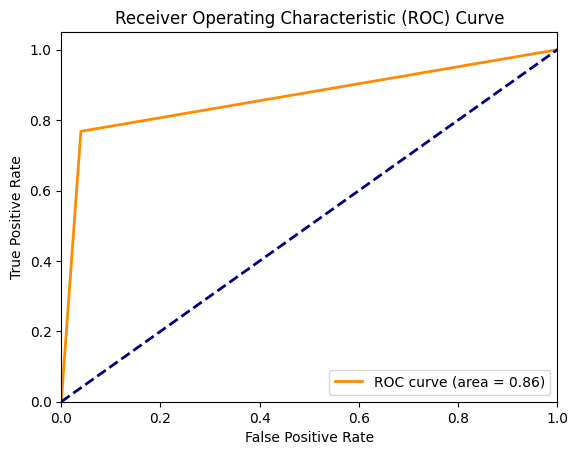

In [389]:
# ROC graph

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_real, result)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('static_roc_curve-hgbc.png')

plt.show()

### Export the test sets

if True:
    column_names = [f'PC{i}' for i in range(1, X_test_layer1.shape[1] + 1)]
    X1_test = pd.DataFrame(data=X_test_layer1, columns=column_names)
    X1_test.to_csv('EvalResources/AdditionalSets/x_test_l1_pca.txt', index=False)
    
    column_names = [f'PC{i}' for i in range(1, X_test_layer2.shape[1] + 1)]
    X2_test = pd.DataFrame(data=X_test_layer2, columns=column_names)
    X2_test.to_csv('EvalResources/AdditionalSets/x_test_l2_pca.txt', index=False)
    
    np.save('EvalResources/AdditionalSets/y_test', y_test_real)

### evaluate seen and unseen attack categories

In [390]:
# load testset
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace = True)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'],axis=1)

df_test_original = df_test

if EXPORT_DATASETS:
    df_test_original.to_csv('EvalResources/ProcessedDatasets/x_test_full.txt', index=False)
    np.save('EvalResources/ProcessedDatasets/y_test_full', y_test)
    
#df_test_original

In [391]:
new_attack = []
for i in df_test_original['label'].value_counts().index.tolist()[1:]:
    if i not in df_train_original['label'].value_counts().index.tolist()[1:]:
        new_attack.append(i)
        
new_attack.sort()
#new_attack

In [392]:
index_of_new_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] in new_attack:
        index_of_new_attacks.append(df_test_original.index[i])

In [393]:
#len(index_of_new_attacks)

In [394]:
new_attack.append('normal')
#new_attack

In [395]:
index_of_old_attacks = []

for i in range(len(df_test_original)):
    if df_test_original['label'][i] not in new_attack:
        index_of_old_attacks.append(df_test_original.index[i])

In [396]:
print('Number of new attacks in the test set: ', result[index_of_new_attacks].shape[0])
print('Number of new attacks detected by the classifiers: ', result[index_of_new_attacks].sum())
print('Proportion of new attacks detected: ', result[index_of_new_attacks].sum()/result[index_of_new_attacks].shape[0])

Number of new attacks in the test set:  3750
Number of new attacks detected by the classifiers:  1977
Proportion of new attacks detected:  0.5272


In [397]:
print('Number of old attacks in the test set: ', result[index_of_old_attacks].shape[0])
print('Number of old attacks detected by the classifiers: ', result[index_of_old_attacks].sum())
print('Proportion of old attacks detected: ', result[index_of_old_attacks].sum()/result[index_of_old_attacks].shape[0])

Number of old attacks in the test set:  9083
Number of old attacks detected by the classifiers:  7881
Proportion of old attacks detected:  0.8676648684355389


### Evaluate single attack types

In [398]:
# load test set
df_test = pd.read_csv('EvalResources/KDDTest+.txt', sep=",", header=None, skipinitialspace = True)
df_test = df_test[df_test.columns[:-1]]
df_test.columns = titles.to_list()
y_test = df_test['label']
df_test = df_test.drop(['num_outbound_cmds'],axis=1)
df_test_original = df_test
df = df_test_original

dos_index = df.index[(df['label'].isin(dos_attacks))].tolist()
probe_index = df.index[(df['label'].isin(probe_attacks))].tolist()
r2l_index = df.index[(df['label'].isin(r2l_attacks))].tolist()
u2r_index = df.index[(df['label'].isin(u2r_attacks))].tolist()

print("Ratio DOS of detection: ", result[dos_index].sum()/result[dos_index].shape[0])

print("Ratio PROBE of detection: ", result[probe_index].sum()/result[probe_index].shape[0])

print("Ratio U2R of detection: ", result[r2l_index].sum()/result[r2l_index].shape[0])

print("Ratio R2L of detection: ", result[u2r_index].sum()/result[u2r_index].shape[0])

print('New attacks detected: ', result[index_of_new_attacks].sum()/result[index_of_new_attacks].shape[0])

print('Old attacks detected: ', result[index_of_old_attacks].sum()/result[index_of_old_attacks].shape[0])

Ratio DOS of detection:  0.8280160857908847
Ratio PROBE of detection:  0.9124328789756299
Ratio U2R of detection:  0.4908145580589255
Ratio R2L of detection:  0.835820895522388
New attacks detected:  0.5272
Old attacks detected:  0.8676648684355389
